### Importing libraries

In [1]:
import matplotlib.pyplot as plt
import glob
import cv2
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
TESTDIR = 'data\\Covid19-dataset\\test'
TRAINDIR = 'data\\Covid19-dataset\\train'

### Number of labels

In [3]:
cnt = 0
for _ in glob.glob(f'{TRAINDIR}\\*'):
    cnt += 1
    print(_)

print(f"There are {cnt} labels")

data\Covid19-dataset\train\Covid
data\Covid19-dataset\train\Normal
data\Covid19-dataset\train\Viral Pneumonia
There are 3 labels


### Show first train and test images

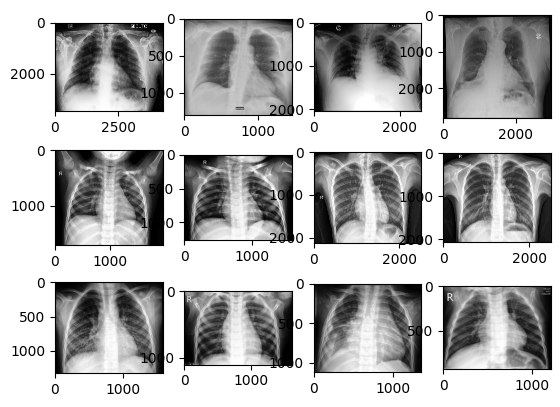

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=4)
for row, label in enumerate(glob.glob(f'{TRAINDIR}\\*')):
    for col, image in enumerate(glob.glob(f'{label}\\*')):
        ax[row,col].imshow(cv2.imread(image)/255.0)
        if col==3:
            break

In [5]:
train_data = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)
test_data = ImageDataGenerator(rescale=1/255.0)

In [6]:
train_set = train_data.flow_from_directory(
    TRAINDIR,
    subset='training',
    batch_size=32,
    target_size=(224,224),
    class_mode='sparse',
)

val_set = train_data.flow_from_directory(
    TRAINDIR,
    subset='validation',
    batch_size=32,
    target_size=(224,224),
    class_mode='sparse',
)

test_set = test_data.flow_from_directory(
    TESTDIR,
    batch_size=32,
    target_size=(224,224),
    class_mode='sparse',
)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [7]:
vgg = VGG19(include_top=False, input_shape=(224,224,3), weights='imagenet')

for layer in vgg.layers:
    layer.trainable = False

In [8]:
ES = tf.keras.callbacks.EarlyStopping(
    patience = 10,
    min_delta = 0.001,
    verbose = 0
)

model = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.2),
    vgg,
    layers.Flatten(),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [9]:
training = model.fit(
    train_set,
    callbacks=[ES],
    steps_per_epoch=7,
    epochs=25,
    validation_data=val_set
)

Epoch 1/25
7/7 [==============================] - 57s 8s/step - loss: 1.9505 - accuracy: 0.4925 - val_loss: 2.2976 - val_accuracy: 0.6200
Epoch 2/25
7/7 [==============================] - 47s 7s/step - loss: 1.0958 - accuracy: 0.6766 - val_loss: 0.9817 - val_accuracy: 0.5200
Epoch 3/25
7/7 [==============================] - 47s 7s/step - loss: 0.7806 - accuracy: 0.7114 - val_loss: 1.1182 - val_accuracy: 0.6800
Epoch 4/25
7/7 [==============================] - 47s 7s/step - loss: 0.5537 - accuracy: 0.7960 - val_loss: 0.7095 - val_accuracy: 0.7600
Epoch 5/25
7/7 [==============================] - 47s 7s/step - loss: 0.4586 - accuracy: 0.8458 - val_loss: 0.5953 - val_accuracy: 0.7800
Epoch 6/25
7/7 [==============================] - 47s 7s/step - loss: 0.2998 - accuracy: 0.8905 - val_loss: 0.4906 - val_accuracy: 0.8000
Epoch 7/25
7/7 [==============================] - 47s 7s/step - loss: 0.2397 - accuracy: 0.9104 - val_loss: 0.3291 - val_accuracy: 0.8600
Epoch 8/25
7/7 [==================

<Axes: title={'center': 'VGG-19 loss curve'}, xlabel='Epochs'>

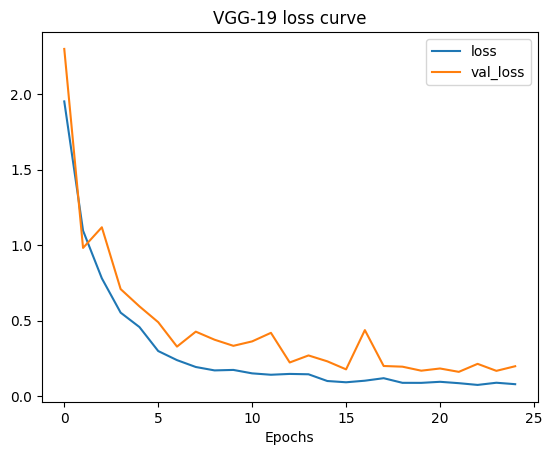

In [10]:
history_df = pd.DataFrame(training.history)
history_df[['loss','val_loss']].plot(title='VGG-19 loss curve', xlabel='Epochs')

In [11]:
prediction_prob = model.predict(test_set)

y_pred = np.argmax(prediction_prob, axis=1)
y_pred

3/3 [==============================] - 12s 3s/step


array([2, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 2, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2,
       0, 2, 0, 2, 0, 2, 1, 2, 2, 2, 0, 0, 2, 0, 1, 2, 1, 1, 0, 2, 1, 1,
       1, 0, 1, 2, 1, 0, 0, 0, 1, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 2, 1, 0],
      dtype=int64)

In [12]:
test_set.class_indices

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

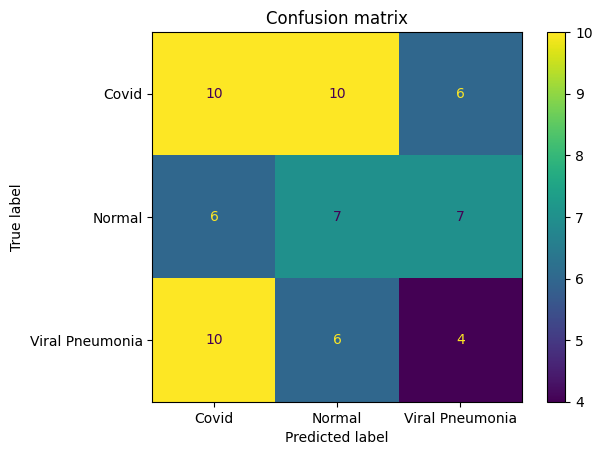

In [13]:
ax = plt.axes()
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_set.labels, y_pred), display_labels=['Covid','Normal','Viral Pneumonia'])
ax.set_title('Confusion matrix')
disp.plot(ax=ax)